In [36]:
import time
import math
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN,Dense, Dropout, Activation
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### Import Data

In [37]:
data = pd.read_csv('nyse_2001-2021.csv')
df=data
df.head()


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,29-11-2001,13.360000,13.386667,371100,14.466667,13.880000,12.583543
1,30-11-2001,13.880000,13.880000,165300,14.266667,14.266667,12.934094
2,03-12-2001,13.783333,14.233333,127500,14.233333,13.783333,12.495903
3,04-12-2001,13.233333,13.783333,95400,13.783333,13.233333,11.997280
4,05-12-2001,13.433333,13.433333,598200,14.783333,14.666667,13.296731


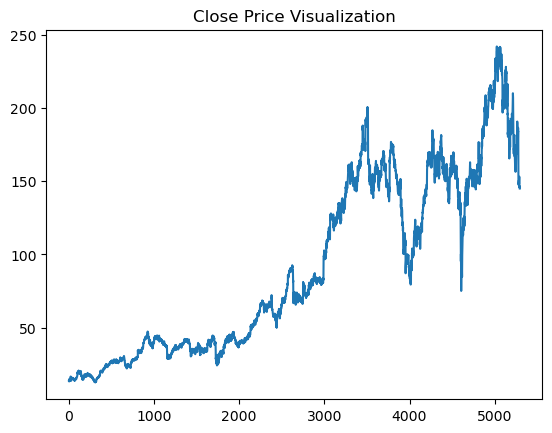

In [38]:
plt.title("Close Price Visualization")
plt.plot(df.Close)

### Defining 200 days moving averages and plotting comparision graph with 100 days moving averages

In [39]:
ma100 = df.Close.rolling(100).mean()
ma100



0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5291    176.1565
5292    175.7703
5293    175.3297
5294    174.8621
5295    174.4132
Name: Close, Length: 5296, dtype: float64

Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

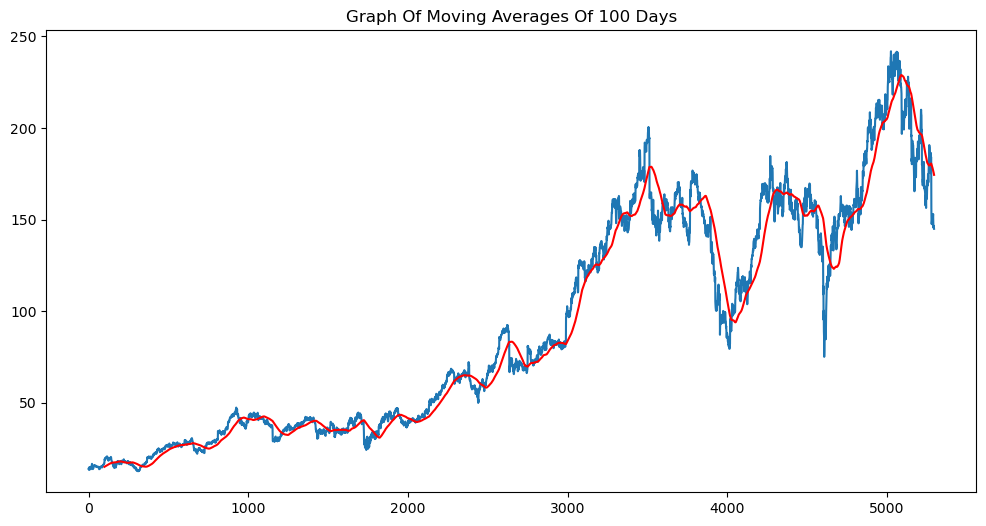

In [40]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.title('Graph Of Moving Averages Of 100 Days')

In [41]:
ma200 = df.Close.rolling(200).mean()
ma200

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
5291    187.62320
5292    187.32265
5293    187.07160
5294    186.79705
5295    186.49390
Name: Close, Length: 5296, dtype: float64

Text(0.5, 1.0, 'Comparision Of 100 Days And 200 Days Moving Averages')

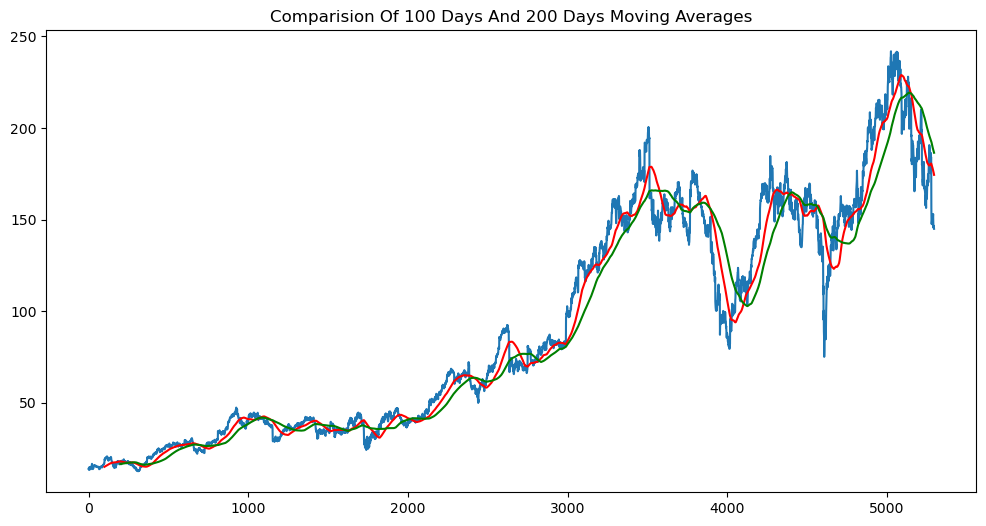

In [42]:

plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.title('Comparision Of 100 Days And 200 Days Moving Averages')

### Data preprocessing

In [43]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Use only the "Close" column for simplicity
close_prices = data['Close'].values.reshape(-1, 1)




C:\Users\stella\AppData\Local\Temp\ipykernel_4220\1768896307.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'])


In [44]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)


#### Splitting data into train, validation, test dataset

In [45]:
N = 100  # use the past 100 days data
M=5 # predict the next 5 days data
# Create sequences
def create_sequences(data, N, M):
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        X.append(data[i:i + N])
        y.append(data[i + N:i + N + M])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, N, M)

# Split into train, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Reshape for LSTM (samples, timesteps, features)
y_train = y_train.reshape(-1, M)
y_val = y_val.reshape(-1, M)
y_test = y_test.reshape(-1, M)

In [46]:
X_train.shape
X_train.shape[1]

100

In [96]:
y_val.shape


(780, 5)

In [97]:
y_test.shape

(780, 5)

### Building vanilla RNN model

In [56]:
# Define vanilla RNN model
# Vanilla RNN, also known as simple RNN
def build_model(input_shape, units=50, lr=0.001):
    model = Sequential([
        SimpleRNN(units, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse',metrics=['MAE'])
    return model

In [57]:
vanilla_model=build_model((X_train.shape[1], X_train.shape[2]))
vanilla_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 50)                2600      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [59]:
from tensorflow.keras.callbacks import EarlyStopping
import optuna

def objective(trial):
    # Suggest hyperparameters
    units = trial.suggest_int('units', 30, 80)
    lr = trial.suggest_loguniform('learning_rate', 1e-3, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [128,256])

    # Build the model
    model = build_model((X_train.shape[1], X_train.shape[2]), units, lr)
     # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train, 
        validation_data=(X_val, y_val), 
        batch_size=batch_size, 
        epochs=20, 
        callbacks=[early_stopping],
        verbose=0
    )
    val_loss = min(history.history['val_loss'])  # Get the best validation loss
    return val_loss

# Hyperparameter tuning with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-12-06 12:04:21,162] A new study created in memory with name: no-name-bdb69544-a81d-46fe-a9a7-73a3630ecd8a
C:\Users\stella\AppData\Local\Temp\ipykernel_4220\1116159094.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('learning_rate', 1e-3, 1e-2)
[I 2024-12-06 12:04:35,947] Trial 0 finished with value: 0.0005179800209589303 and parameters: {'units': 70, 'learning_rate': 0.004485643006233375, 'batch_size': 128}. Best is trial 0 with value: 0.0005179800209589303.
[I 2024-12-06 12:04:48,981] Trial 1 finished with value: 0.000586017151363194 and parameters: {'units': 63, 'learning_rate': 0.0012957458034643635, 'batch_size': 128}. Best is trial 0 with value: 0.0005179800209589303.
[I 2024-12-06 12:04:57,207] Trial 2 finished with value: 0.0005992412916384637 and parameters: {'units': 50, 'learn

Best Hyperparameters: {'units': 48, 'learning_rate': 0.009190017784696084, 'batch_size': 128}


In [61]:

# Train the final model with the best hyperparameters
final_model = build_model(
    (X_train.shape[1], X_train.shape[2]), 
    best_params['units'], 
    best_params['learning_rate']
)
# continue to train the model with best hyperparameters
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = final_model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    batch_size=best_params['batch_size'], 
    callbacks=[early_stopping],
    epochs=30
)

Epoch 1/30
29/29 [==============================] - 3s 29ms/step - loss: 0.0142 - MAE: 0.0948 - val_loss: 4.1663e-04 - val_MAE: 0.0149
Epoch 2/30
29/29 [==============================] - 1s 20ms/step - loss: 0.0012 - MAE: 0.0263 - val_loss: 5.8768e-04 - val_MAE: 0.0186
Epoch 3/30
29/29 [==============================] - 1s 20ms/step - loss: 2.3235e-04 - MAE: 0.0113 - val_loss: 6.3823e-04 - val_MAE: 0.0196
Epoch 4/30
29/29 [==============================] - 1s 19ms/step - loss: 1.8760e-04 - MAE: 0.0098 - val_loss: 4.8506e-04 - val_MAE: 0.0167
Epoch 5/30
29/29 [==============================] - 1s 20ms/step - loss: 2.5340e-04 - MAE: 0.0119 - val_loss: 5.5921e-04 - val_MAE: 0.0180
Epoch 6/30
29/29 [==============================] - 1s 20ms/step - loss: 7.2602e-04 - MAE: 0.0227 - val_loss: 7.3798e-04 - val_MAE: 0.0220


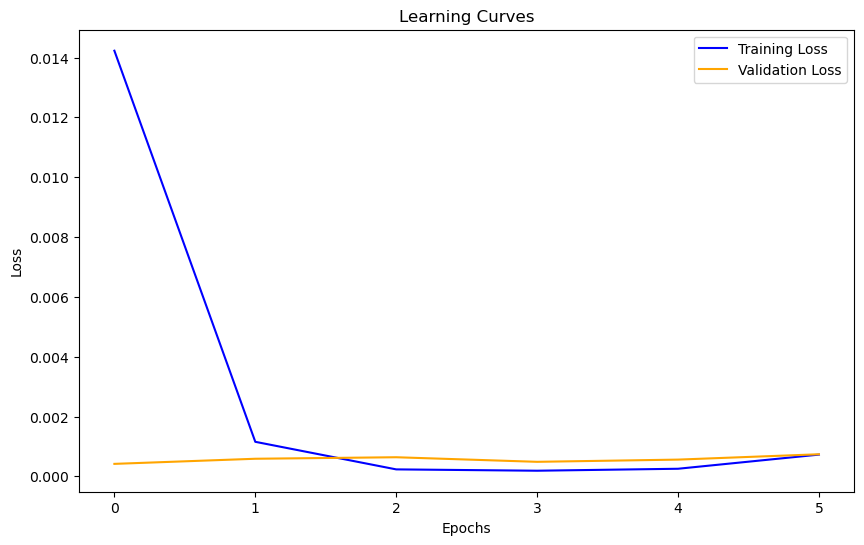

In [121]:
# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()
plt.show()

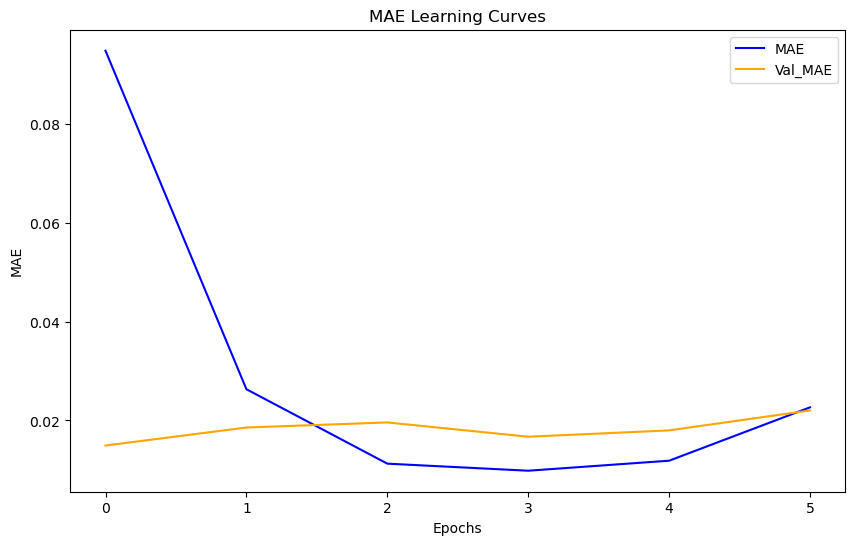

In [124]:

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['MAE'], label='MAE', color='blue')
plt.plot(history.history['val_MAE'], label='Val_MAE', color='orange')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('MAE Learning Curves')
plt.legend()
plt.show()

In [111]:
# Predictions and plot actual vs predicted prices
y_pred = final_model.predict(X_test)


25/25 [==============================] - 0s 5ms/step


In [112]:
# Inverse scale predictions
y_test_scaled = scaler.inverse_transform(y_test)
y_pred_scaled = scaler.inverse_transform(y_pred.reshape(-1, 1))

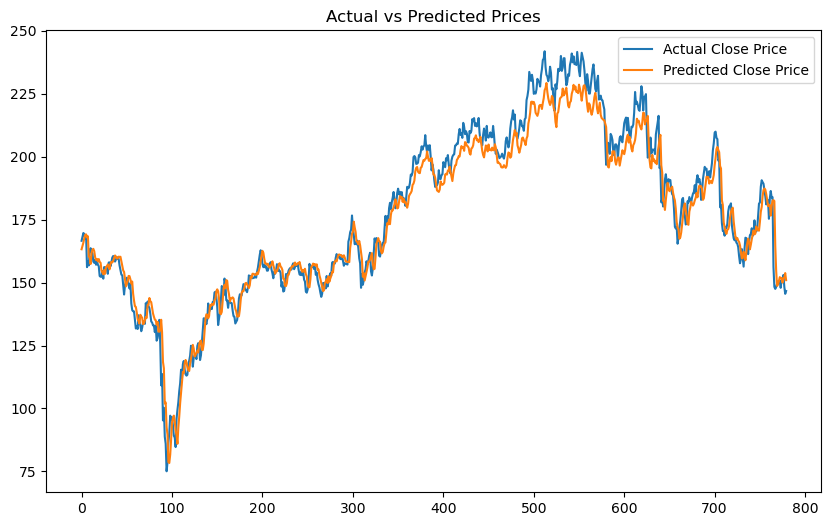

In [113]:

plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled[:,1], label='Actual Close Price ')  # Close price index
plt.plot(y_pred_scaled, label='Predicted Close Price')
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()

In [120]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Calculate metrics
mse = mean_squared_error(y_test[:,1], y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test[:,1], y_pred)

# Print results
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test MAE: {mae:.2f}")

Test MSE: 0.00
Test RMSE: 0.03
Test MAE: 0.02
